In [19]:
its_jupyter_notebook = True

In [20]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from models.nt_classifier import build as build_model
from config import *
from util.plot_utils import obtain_plot, plot_logs, plot_roc_curves, collect_results_based_on_confidence_level
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

In [21]:
HOW = 'test'

assert HOW in ['val', 'test']

In [22]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', 'binary_cl2_2_RANDOM') #'binary_cl2_1e36_RANDOM'

In [23]:
# Define the path to the file containing the args namespace
args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)
    
print(args_dict)

{'lr': 0.0001, 'lr_backbone': 0.0001, 'batch_size': 32, 'weight_decay': 0.0001, 'epochs': 300, 'lr_drop': 200, 'clip_max_norm': 0.1, 'proj_module_N_channels': 0, 'proj_module_secondary_structure_N_channels': 4, 'drop_secondary_structure': False, 'use_projection_module': False, 'dropout_prob': 0.2, 'args.mini_batch_size': 32, 'num_hidden_layers': 0, 'dividing_factor': 10, 'output_channels_mlp': 800, 'n_channels1_cnn': 600, 'n_channels2_cnn': 600, 'min_n_groups_train': 5, 'max_n_groups_train': 80, 'min_n_groups_val': 80, 'max_n_groups_val': 80, 'policies_train': [<dataset.data.EasyPosAugment object at 0x7f1d15751dc0>, <dataset.data.SmartNegAugment object at 0x7f1e2e9b49d0>], 'policies_val': [<dataset.data.EasyPosAugment object at 0x7f1d15751b20>, <dataset.data.SmartNegAugment object at 0x7f1d15751a00>], 'dataset_path': '/data01/giorgio/RNARNA-NT/dataset', 'device': 'cuda', 'seed': 42, 'num_workers': 2, 'output_dir': '/data01/giorgio/RNARNA-NT/checkpoints/binary_cl2', 'resume': '/data01/g

In [24]:
#args_dict['policies_train'][0].height_probabilities

In [25]:
#args_dict['policies_train'][0].height_bins

In [26]:
file_train = os.path.join(rna_rna_files_dir, "RANDOM", "gene_pairs_training.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train_original = pickle.load(fp)

file_train = os.path.join(rna_rna_files_dir, "RANDOM", "gene_pairs_training_nt.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train = pickle.load(fp)
    
file_test = os.path.join(rna_rna_files_dir, "RANDOM", f"gene_pairs_{HOW}_nt.txt")
with open(file_test, "rb") as fp:   # Unpickling
    gene_pairs_test = pickle.load(fp)
    
file_test_subset = os.path.join(rna_rna_files_dir, "RANDOM", f"gene_pairs_{HOW}_sampled_nt.txt")
with open(file_test_subset, "rb") as fp:   # Unpickling
    gene_pairs_test_subset = pickle.load(fp)

In [27]:
test500 = pd.read_csv(os.path.join(metadata_dir, 'RANDOM', f'{HOW}500.csv'))
assert test500.couples.isin(gene_pairs_test).all()

In [28]:
# collect simple_repeats_id, sine_alu_id, low_complex_id info 


repeats_info = pd.read_csv(os.path.join(original_files_dir, f'index_repeats.Tx.RI_ALL.txt'), sep = '\t')[['name_1', 'Simple_repeat_unknown', 'SINE_Alu', 'Low_complexity_unknown']]

def check_for_R(value):
    return 'R' in value

repeats_info['Simple_repeat_unknown'] = repeats_info['Simple_repeat_unknown'].apply(check_for_R)
simple_repeats = set(repeats_info[repeats_info.Simple_repeat_unknown].name_1)
    
repeats_info['SINE_Alu'] = repeats_info['SINE_Alu'].apply(check_for_R)
sine_alu = set(repeats_info[repeats_info.SINE_Alu].name_1)

repeats_info['Low_complexity_unknown'] = repeats_info['Low_complexity_unknown'].apply(check_for_R)
low_complex = set(repeats_info[repeats_info.Low_complexity_unknown].name_1)

import dataset.preprocessing as utils
info = utils.read_dataframe(os.path.join(original_files_dir, 'index_bio_regions.Tx.RI_ALL.txt'), columns_to_drop = ['Unnamed: 0'])
info = info[['name','ensembl_gene_id_1', 'ensembl_gene_id_2', 'start_1', 'end_1', 'start_2', 'end_2']]
info = info.rename({'ensembl_gene_id_1':'gene_id1', 'ensembl_gene_id_2':'gene_id2', 'start_1': 'x1','end_1': 'x2','start_2': 'y1','end_2': 'y2'}, axis = 1)
info[['couples', 'need_to_swap']] = info[['gene_id1', 'gene_id2']].apply(utils.create_pairs, axis = 1)
def swap_genes_if_needed(df):
    original_dim = df.shape[0]
    where = df.need_to_swap
    df.loc[where, ['gene_id1', 'gene_id2']] = (df.loc[where, ['gene_id2', 'gene_id1']].values)
    df.loc[where, ['x1', 'y1']] = (df.loc[where, ['y1', 'x1']].values)
    df.loc[where, ['x2', 'y2']] = (df.loc[where, ['y2', 'x2']].values)
    df = df.drop('need_to_swap', axis = 1)
    df = df.drop_duplicates().reset_index(drop = True)
    n_duplicates = original_dim - df.shape[0] 
    print(f"{n_duplicates} interactions were duplicated (the genes were swopped, now they have a unique couples_id so I can see only now that they are duplicated)")
    return df
info = swap_genes_if_needed(info)

simple_repeats = info[info.name.isin(simple_repeats)]
sine_alu = info[info.name.isin(sine_alu)]
low_complex = info[info.name.isin(low_complex)]

hq_test = test500.copy()
regex1 = hq_test.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index()
regex2 = hq_test.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index()
hq_test['g1g2_id'] = regex1[0] + '_' + regex2[0]
hq_test['x1_window'] = regex1[1]
hq_test['y1_window'] = regex2[1]
hq_test[['x1_window', 'y1_window']] = hq_test[['x1_window', 'y1_window']].apply(pd.to_numeric)

hq_test['real_seed_x1'] = hq_test['x1_window'] + hq_test['seed_x1']
hq_test['real_seed_x2'] = hq_test['x1_window'] + hq_test['seed_x2']
hq_test['real_seed_y1'] = hq_test['y1_window'] + hq_test['seed_y1']
hq_test['real_seed_y2'] = hq_test['y1_window'] + hq_test['seed_y2']

hq_test = hq_test[['couples', 'g1g2_id', 'real_seed_x1', 'real_seed_x2', 'real_seed_y1', 'real_seed_y2']].rename(
    {'couples':'real_id_couple', 'g1g2_id': 'couples', 'real_seed_x1':'x1', 'real_seed_x2':'x2', 
     'real_seed_y1':'y1', 'real_seed_y2':'y2'}, axis = 1)

simple_repeats_id = set(hq_test.merge(simple_repeats, on = ['couples', 'x1', 'x2', 'y1', 'y2']).real_id_couple)
sine_alu_id = set(hq_test.merge(sine_alu, on = ['couples', 'x1', 'x2', 'y1', 'y2']).real_id_couple)
low_complex_id = set(hq_test.merge(low_complex, on = ['couples', 'x1', 'x2', 'y1', 'y2']).real_id_couple)

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (2,4,6,8,22,26,36,37,42,44,45,46,56,57,58,59,60,61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0 interactions were duplicated (the genes were swopped, now they have a unique couples_id so I can see only now that they are duplicated)


In [29]:
res = pd.read_csv(os.path.join(checkpoint_dir, f'{HOW}_results500.csv'))

# Drop all the pairs (they should be 60-70) that are present in the training set.
res = res[~res.couples.isin(gene_pairs_train_original)]

print(classification_report(res.ground_truth, res.prediction))

              precision    recall  f1-score   support

           0       0.78      0.62      0.69     31307
           1       0.44      0.64      0.52     14706

    accuracy                           0.63     46013
   macro avg       0.61      0.63      0.61     46013
weighted avg       0.67      0.63      0.64     46013



# PLOTS

In [30]:
def balance_df(df, n_iter = 25):
    toappend = []
    if df[df.ground_truth == 0].shape[0] > df[df.ground_truth == 1].shape[0]:
        for i in range(n_iter):
            negs = df[df.ground_truth == 0]
            poss = df[df.ground_truth == 1]
            toappend.append(pd.concat([negs.sample(len(poss)), poss], axis = 0))
    else:
        for i in range(n_iter):
            negs = df[df.ground_truth == 0]
            poss = df[df.ground_truth == 1]
            toappend.append(pd.concat([poss.sample(len(negs)), negs], axis = 0))
    balanced = pd.concat(toappend, axis = 0)
    return balanced

### Log plots

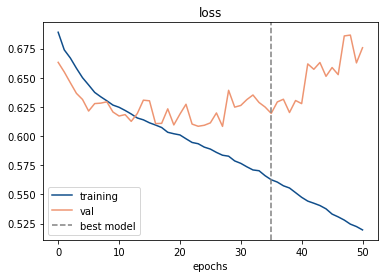

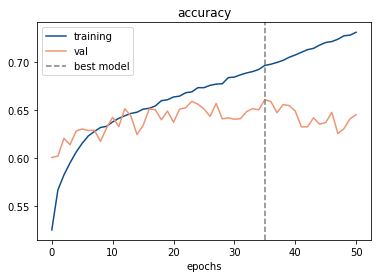

In [31]:
log = pd.read_json(Path(os.path.join(checkpoint_dir, 'log.txt')), lines=True)
best_model = np.argmax(log.test_accuracy)
for metric in ['loss', 'accuracy']:
    plot_logs(log, metric, best_model = best_model)

## Metrics

In [32]:
print(res.prediction.value_counts())
print('\n')
print(res.ground_truth.value_counts())

0    24683
1    21330
Name: prediction, dtype: int64


0    31307
1    14706
Name: ground_truth, dtype: int64


In [33]:
n_conf = 10

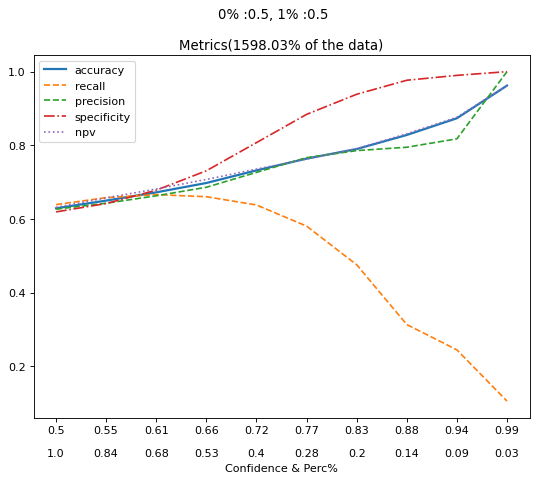

In [34]:
obtain_plot(balance_df(res), n_original_df = res.shape[0], title = 'Metrics', n_conf = n_conf)

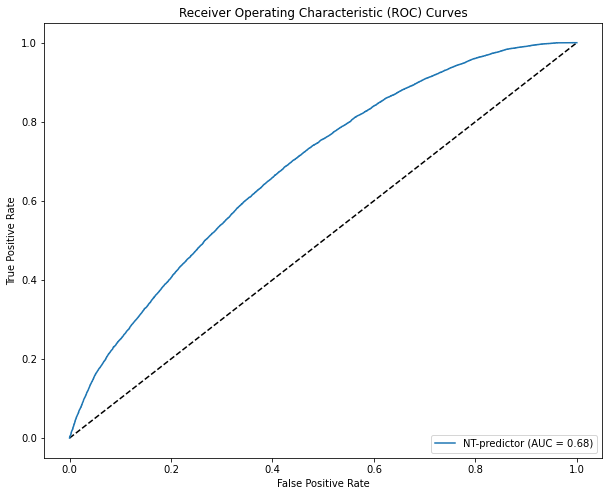

In [35]:
plot_roc_curves([{'prob': res.probability, 'model_name': 'NT-predictor'}], res.ground_truth)

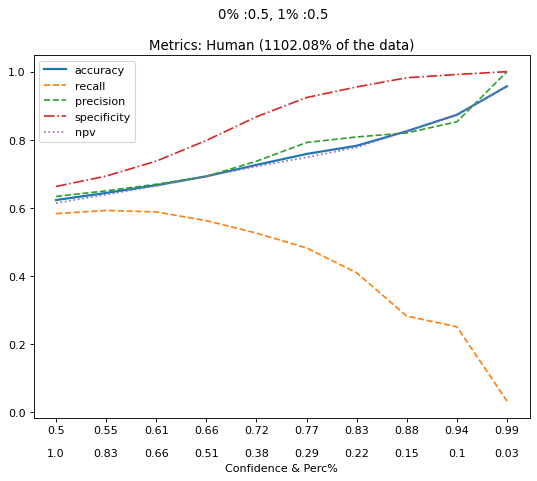

In [36]:
human = res[(res.specie == 'human')]
obtain_plot(balance_df(human), n_original_df = res.shape[0], title = f'Metrics: Human ', n_conf = n_conf)

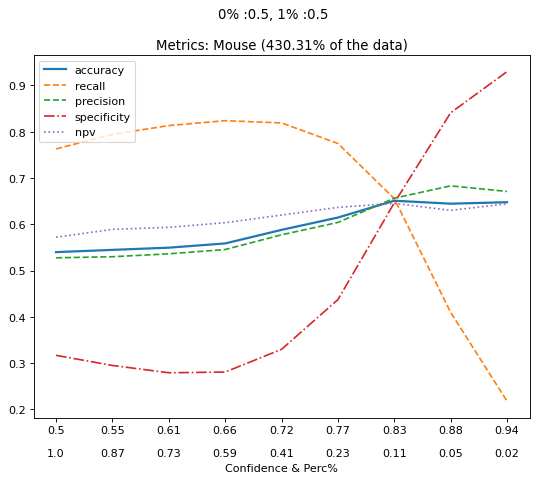

In [37]:
mouse = res[(res.specie == 'mouse')]
obtain_plot(balance_df(mouse), n_original_df = res.shape[0], title = f'Metrics: Mouse ', n_conf = n_conf)

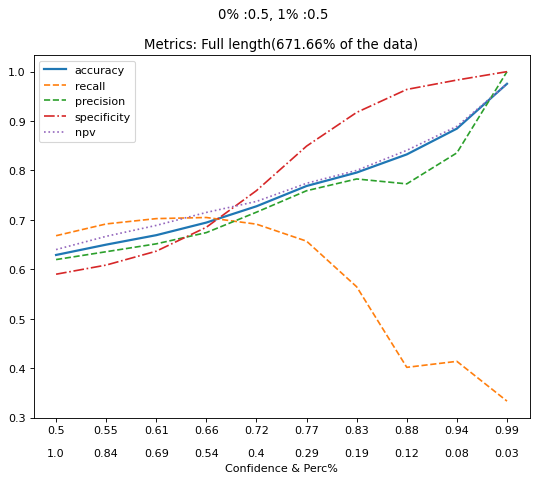

In [38]:
full_length = res[(res.original_length1 <= MAX_RNA_SIZE)&(res.original_length2 <= MAX_RNA_SIZE)]
obtain_plot(balance_df(full_length), n_original_df = res.shape[0], title = f'Metrics: Full length', n_conf = 10)

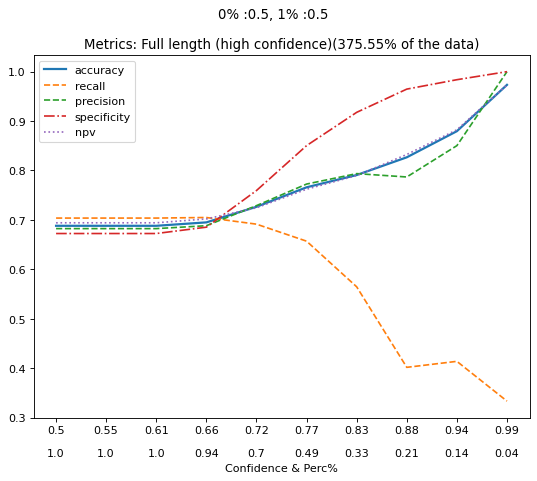

In [39]:
confidence_level = 0.65
high_conf_fl = full_length[(full_length.probability>confidence_level)|(full_length.probability<(1-confidence_level))]
obtain_plot(balance_df(high_conf_fl), n_original_df = res.shape[0], title = f'Metrics: Full length (high confidence)', n_conf = n_conf)

In [80]:
# big_area_size = res.sampled_area.quantile(0.9)
# big_area_size = 5000**2
# big_area = res[res['sampled_area'] > big_area_size]

# obtain_plot(big_area, n_original_df = res.shape[0], title = f'Metrics: Big area', n_conf = n_conf)

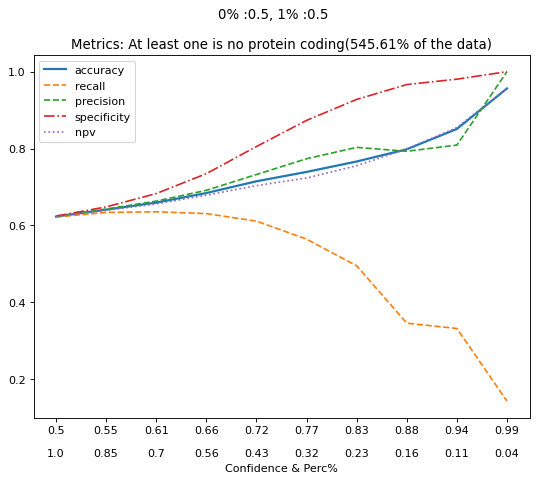

In [40]:
no_pc = res[(res['gene1_pc'] == False)|(res['gene2_pc'] == False)]

obtain_plot(balance_df(no_pc), n_original_df = res.shape[0], title = f'Metrics: At least one is no protein coding', n_conf = n_conf)

0.6656643488066153


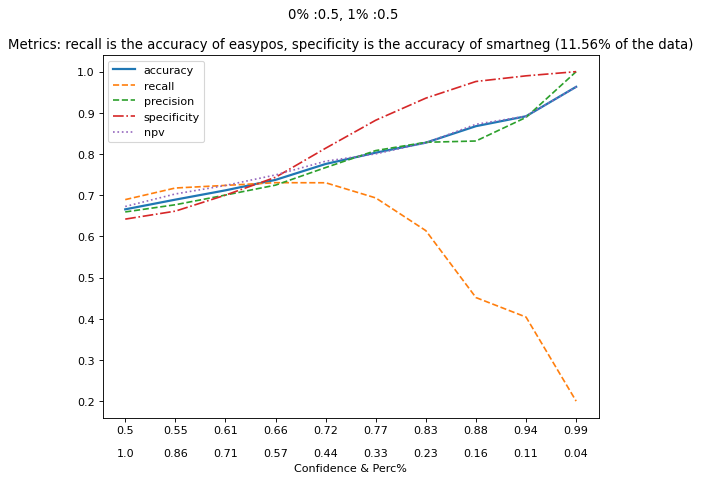

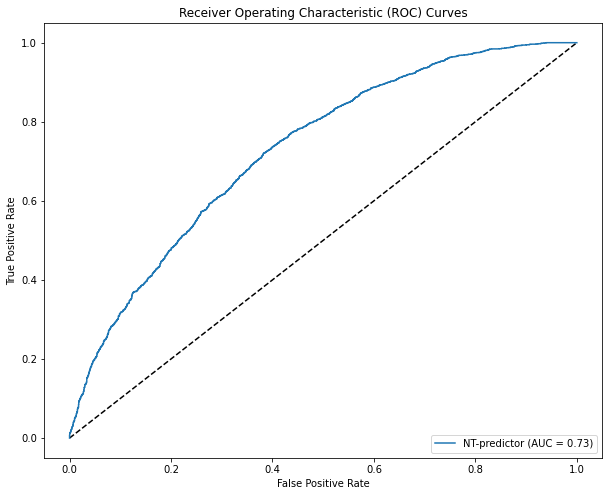

In [41]:
subset_test_nt_sampled = os.path.join(rna_rna_files_dir, 'RANDOM', f"gene_pairs_{HOW}_sampled_nt.txt")
with open(subset_test_nt_sampled, "rb") as fp:  # Unpickling
    subset_test_nt_sampled = pickle.load(fp)
    
easypos_smartneg_HQ = res[res.id_sample.isin(subset_test_nt_sampled)]

# easypos_smartneg_HQ = easypos_smartneg_HQ[easypos_smartneg_HQ.specie == 'human']
# easypos_smartneg_HQ = balance_df(easypos_smartneg_HQ)

# vc = easypos_smartneg.ground_truth.value_counts()
# assert vc.loc[1] > vc.loc[0]
# n_to_exclude = vc.loc[1] - vc.loc[0]
# easypos_gt = easypos_smartneg[easypos_smartneg.ground_truth==1]
# id_to_exclude = list(easypos_gt.sample(frac = 1).head(n_to_exclude).id_sample)
# easypos_smartneg_sampled = easypos_smartneg[~easypos_smartneg.id_sample.isin(id_to_exclude)]

easypos_smartneg_sampled = easypos_smartneg_HQ
print((easypos_smartneg_sampled.prediction == easypos_smartneg_sampled.ground_truth).sum()/easypos_smartneg_sampled.shape[0])
obtain_plot(easypos_smartneg_sampled, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg ', n_conf = n_conf)
plot_roc_curves([{'prob': easypos_smartneg_sampled.probability, 'model_name': 'NT-predictor'}], easypos_smartneg_sampled.ground_truth)

In [42]:
from scipy.stats import chi2_contingency, fisher_exact

how = 'fisher'

def calc_test(ep, list_id, how = 'chi2'):
    
    sr = ep[ep.id_sample.isin(list_id)]
    no_sr = ep[~ep.id_sample.isin(list_id)]
    
    a = sr[sr.prediction == 1].shape[0]
    b = no_sr[no_sr.prediction == 1].shape[0]
    c = sr[sr.prediction == 0].shape[0]
    d = no_sr[no_sr.prediction == 0].shape[0]
    test(a, b, c, d, how = how)

def test(a, b, c, d, how):
    # Crea una tabella di contingenza tra veri positivi e falsi negativi rispetto a SIMPLE_REPEAT
    # Ad esempio, supponiamo che tu abbia i seguenti dati:
    #           | SIMPLE_REPEAT = True  | SIMPLE_REPEAT = False
    # ----------------------------------------------
    # Veri Positivi   |       a              |       b
    # Falsi Negativi  |       c              |       d


    # Crea la tabella di contingenza
    observed = np.array([[a, b], [c, d]])
    
    if how=='chi2':
        # Esegue il test del chi-quadro per l'indipendenza
        chi2, p, _, _ = chi2_contingency(observed)

    else:
        odds_ratio, p = fisher_exact([[a, b], [c, d]])
        
    # Valuta la significatività
    alpha = 0.05
    if p < alpha:
        print(f"Il test è statisticamente significativo (p = {np.round(p, 2)}).")
        print("Ci sono evidenze di un'associazione tra Veri Positivi/Falsi Negativi e Variabile (es.Simple Repeat).")
    else:
        print(f"Il test non è statisticamente significativo (p = {np.round(p, 2)}).")

# TODO: FAI TEST DI FISHER SU QUESTI

#simple_repeats_id, sine_alu_id, low_complex_id
ep = res[(res.policy == 'easypos')]
print(f'easypos accuracy: {ep[ep.prediction == 1].shape[0]/ep.shape[0]}')

sr = ep[ep.id_sample.isin(simple_repeats_id)]
print(f'\n simple repeat accuracy: {sr[sr.prediction == 1].shape[0]/sr.shape[0]}. The # of simple repeat samples is {np.round(sr.shape[0]/ep.shape[0] * 100, 2)}% of the positives.')
calc_test(ep, simple_repeats_id, how = how)


sa = ep[ep.id_sample.isin(sine_alu_id)]
print(f'\n sine alu accuracy: {sa[sa.prediction == 1].shape[0]/sa.shape[0]}. The # of simple repeat samples is {np.round(sa.shape[0]/ep.shape[0] * 100, 2)}% of the positives.')
calc_test(ep, sine_alu_id, how = how)


lc = ep[ep.id_sample.isin(low_complex_id)]
print(f'\n low complexity accuracy: {lc[lc.prediction == 1].shape[0]/lc.shape[0]}. The # of simple repeat samples is {np.round(lc.shape[0]/ep.shape[0] * 100, 2)}% of the positives.')
calc_test(ep, low_complex_id, how = how)


print('\n ------ HQ ------ \n')

ep = easypos_smartneg_sampled[(easypos_smartneg_sampled.policy == 'easypos')]
print(f'\n easypos accuracy: {ep[ep.prediction == 1].shape[0]/ep.shape[0]}')

sr = ep[ep.id_sample.isin(simple_repeats_id)]
print(f'\n simple repeat accuracy: {sr[sr.prediction == 1].shape[0]/sr.shape[0]}. The # of simple repeat samples is {np.round(sr.shape[0]/ep.shape[0] * 100, 2)}% of the positives.')
calc_test(ep, simple_repeats_id, how = how)

sa = ep[ep.id_sample.isin(sine_alu_id)]
print(f'\n sine alu accuracy: {sa[sa.prediction == 1].shape[0]/sa.shape[0]}. The # of simple repeat samples is {np.round(sa.shape[0]/ep.shape[0] * 100, 2)}% of the positives.')
calc_test(ep, sine_alu_id, how = how)

lc = ep[ep.id_sample.isin(low_complex_id)]
print(f'\n low complexity accuracy: {lc[lc.prediction == 1].shape[0]/lc.shape[0]}. The # of simple repeat samples is {np.round(lc.shape[0]/ep.shape[0] * 100, 2)}% of the positives.')
calc_test(ep, low_complex_id, how = how)

easypos accuracy: 0.6388548891608867

 simple repeat accuracy: 0.6782911944202267. The # of simple repeat samples is 7.8% of the positives.
Il test è statisticamente significativo (p = 0.0).
Ci sono evidenze di un'associazione tra Veri Positivi/Falsi Negativi e Variabile (es.Simple Repeat).

 sine alu accuracy: 0.6138415245737212. The # of simple repeat samples is 13.56% of the positives.
Il test è statisticamente significativo (p = 0.01).
Ci sono evidenze di un'associazione tra Veri Positivi/Falsi Negativi e Variabile (es.Simple Repeat).

 low complexity accuracy: 0.7154471544715447. The # of simple repeat samples is 0.84% of the positives.
Il test non è statisticamente significativo (p = 0.09).

 ------ HQ ------ 


 easypos accuracy: 0.68928035982009

 simple repeat accuracy: 0.6597938144329897. The # of simple repeat samples is 7.27% of the positives.
Il test non è statisticamente significativo (p = 0.38).

 sine alu accuracy: 0.7536023054755043. The # of simple repeat samples is 2

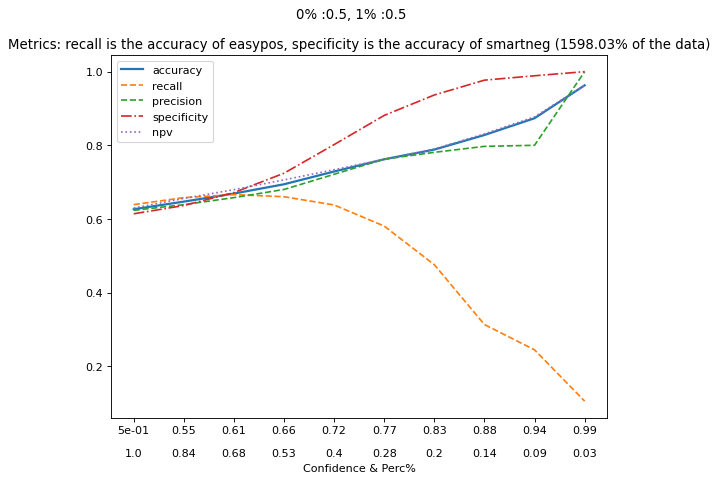

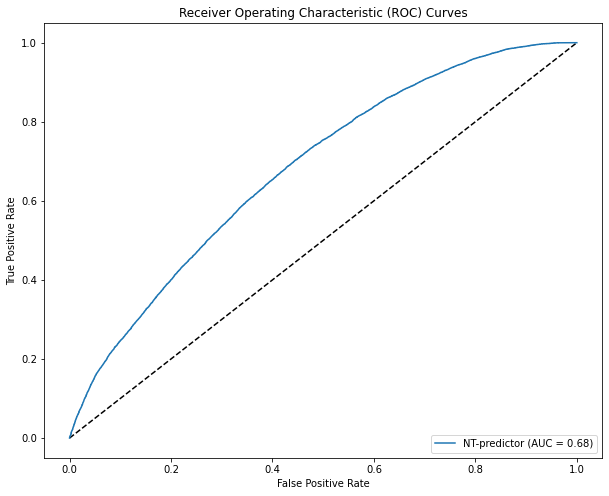

In [43]:
subset_test_nt_sampled = os.path.join(rna_rna_files_dir, 'RANDOM', f"gene_pairs_{HOW}.txt")
with open(subset_test_nt_sampled, "rb") as fp:  # Unpickling
    subset_test_nt_sampled = pickle.load(fp)
    
all_val = res[res.couples.isin(subset_test_nt_sampled)]
assert all_val.shape[0] == res.shape[0]
easypos_smartneg = all_val[all_val.policy.isin(['smartneg', 'easypos'])]


obtain_plot(balance_df(easypos_smartneg), n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg ', n_conf = n_conf)
plot_roc_curves([{'prob': easypos_smartneg.probability, 'model_name': 'NT-predictor'}], easypos_smartneg.ground_truth)

Text(0, 0.5, 'Accuracy SmartNeg VS EasyPos')

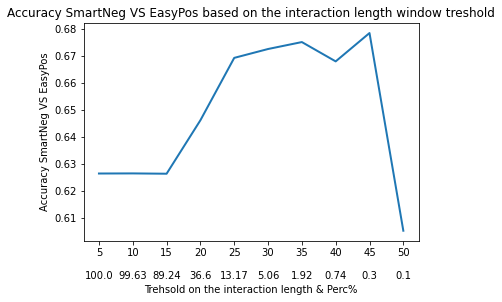

In [44]:
def obtain_acc_and_perc(treshold, res, test500):
    original_res_shape = res.shape[0]
    #take only big windows
    subset = test500[ (abs(test500.seed_x1 - test500.seed_x2) >treshold) & (abs(test500.seed_y1 - test500.seed_y2) > treshold) ]
    res = res[res.id_sample.isin(subset.couples)]
    
    perc = np.round((res.shape[0] / original_res_shape)*100, 2)
    
    res = balance_df(res)

    acc = (res.prediction == res.ground_truth).sum()/res.shape[0]
    return acc, perc

tresholds = np.linspace(5, 50, 10).astype(int)
accuracies = []
percs = []
for treshold in tresholds:
    acc, perc = obtain_acc_and_perc(treshold, easypos_smartneg, test500)
    accuracies.append(acc)
    percs.append(perc)

merged_x_axis = []
for i in range(0, len(percs)):
    tuple_to_print = (np.round(tresholds[i],2), np.round(percs[i], 2))
    merged_x_axis.append('\n\n'.join(str(x) for x in tuple_to_print))

plt.title('Accuracy SmartNeg VS EasyPos based on the interaction length window treshold')

plt.plot(merged_x_axis, accuracies, label = 'accuracy', linewidth=2)

plt.xlabel(f"Trehsold on the interaction length & Perc%")
plt.ylabel(f"Accuracy SmartNeg VS EasyPos")

0.6045364891518737


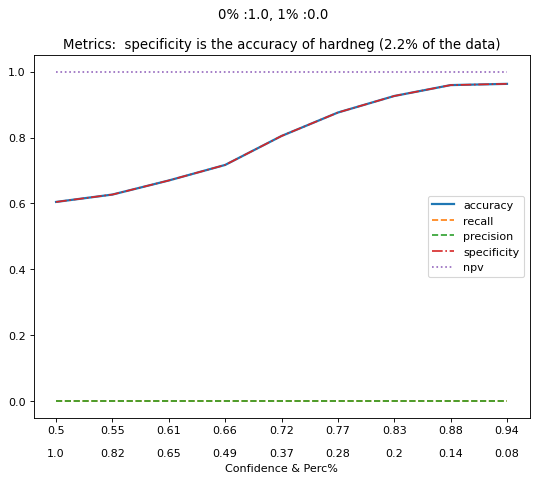

In [45]:
hn = res[(res.policy == 'hardneg')]
print(hn[hn.ground_truth == hn.prediction].shape[0]/hn.shape[0])

obtain_plot(hn, n_original_df = res.shape[0], title = f'Metrics:  specificity is the accuracy of hardneg ', n_conf = n_conf)

0.735202492211838


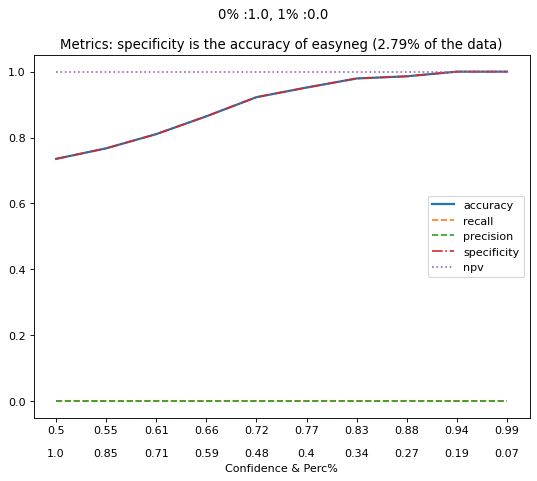

In [46]:
easy = res[(res.policy == 'easyneg')]
print(easy[easy.ground_truth == easy.prediction].shape[0]/easy.shape[0])

obtain_plot(easy, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg ', n_conf = n_conf)

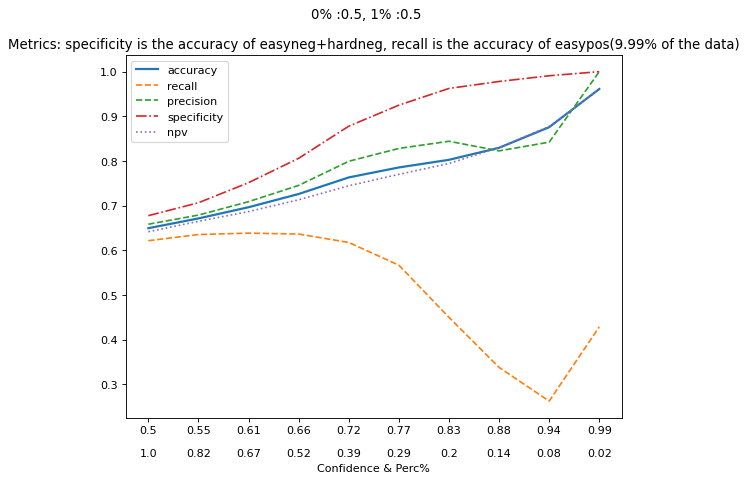

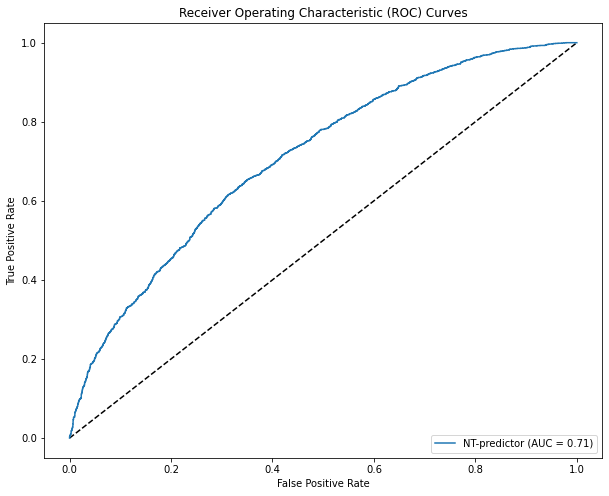

In [47]:
ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')]

vc = ephnen.ground_truth.value_counts()
assert vc.loc[1] > vc.loc[0]
n_to_exclude = vc.loc[1] - vc.loc[0]
ephnen_gt = ephnen[ephnen.ground_truth==1]
id_to_exclude = list(ephnen_gt.sample(frac = 1).head(n_to_exclude).id_sample)
ephnen_sampled = ephnen[~ephnen.id_sample.isin(id_to_exclude)]

obtain_plot(ephnen_sampled, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg+hardneg, recall is the accuracy of easypos', n_conf = n_conf)
plot_roc_curves([{'prob': ephnen_sampled.probability, 'model_name': 'NT-predictor'}], ephnen_sampled.ground_truth)

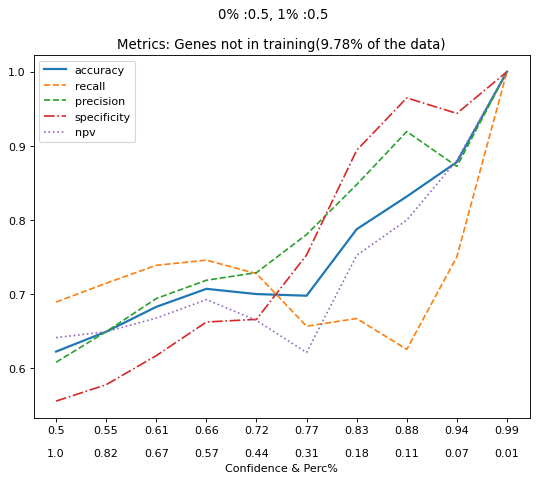

In [48]:
df_nt = pd.read_csv(os.path.join(metadata_dir, 'RANDOM', f'df_nt.csv'))
regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
df_train = regex
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

not_in_train = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]

obtain_plot(balance_df(not_in_train), n_original_df = res.shape[0], title = f'Metrics: Genes not in training', n_conf = n_conf)

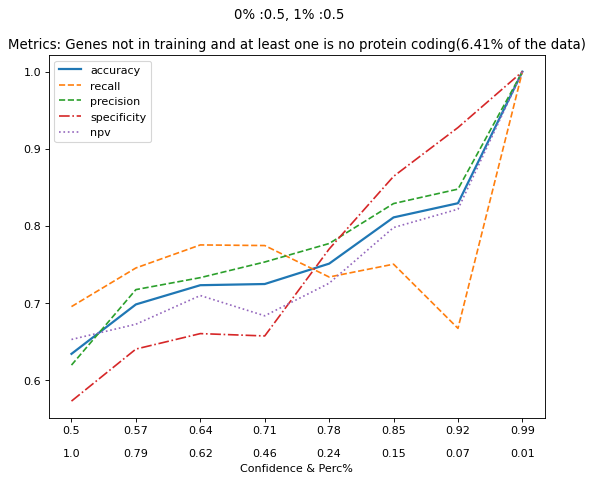

In [49]:
no_pc_no_train = not_in_train[(not_in_train['gene1_pc'] == False)|(not_in_train['gene2_pc'] == False)]

obtain_plot(balance_df(no_pc_no_train), n_original_df = res.shape[0], title = f'Metrics: Genes not in training and at least one is no protein coding', n_conf = 8)

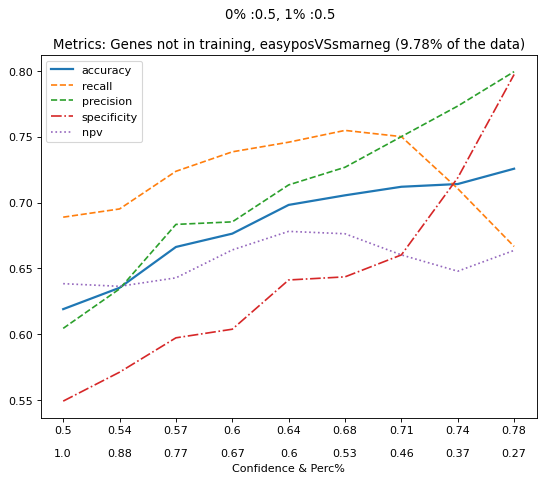

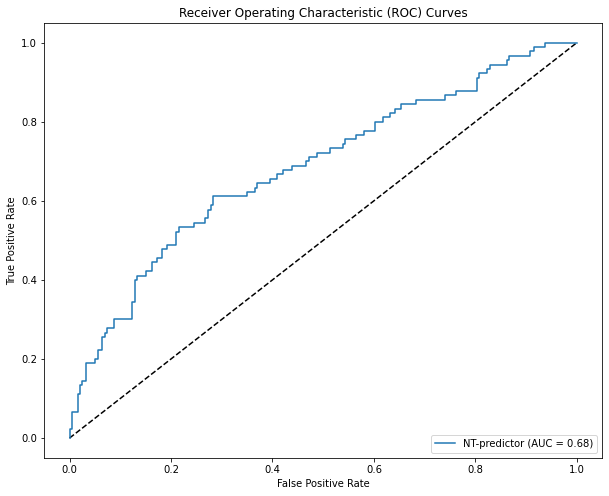

In [50]:
not_in_train_epsn = not_in_train[(not_in_train.policy == 'easypos')|(not_in_train.policy == 'smartneg')]
not_in_train_epsn_balanced = balance_df(not_in_train_epsn)
obtain_plot(not_in_train_epsn_balanced, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, easyposVSsmarneg ', n_conf = 15, excluding_treshold = 0.2)
plot_roc_curves([{'prob': not_in_train_epsn_balanced.probability, 'model_name': 'NT-predictor'}], not_in_train_epsn_balanced.ground_truth)

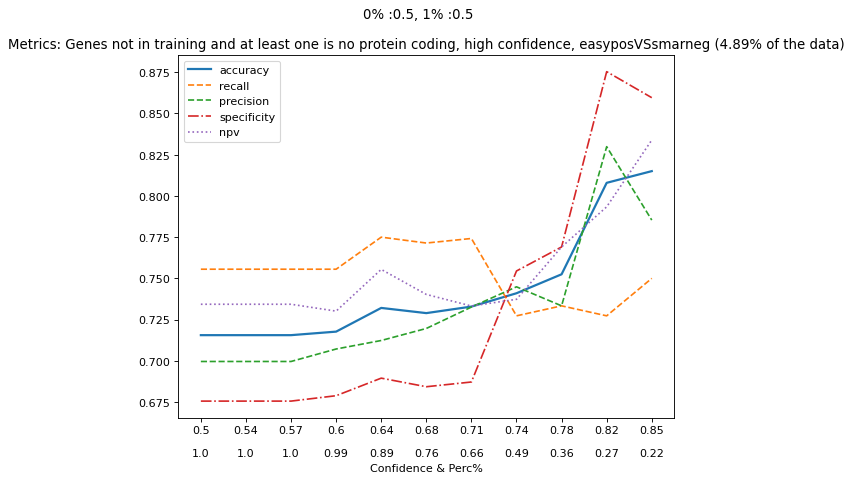

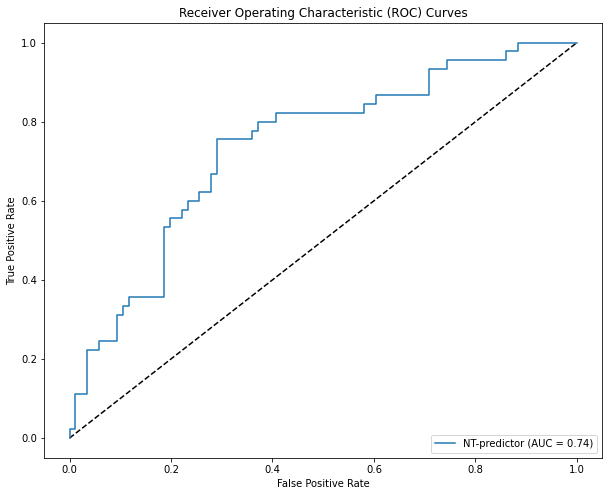

In [51]:
confidence_level = 0.6

no_pc_no_train = not_in_train[(not_in_train['gene1_pc'] == False)|(not_in_train['gene2_pc'] == False)]
no_pc_no_train = no_pc_no_train[(no_pc_no_train.probability>confidence_level)|(no_pc_no_train.probability<(1-confidence_level))]
no_pc_no_train = no_pc_no_train[(no_pc_no_train.policy == 'easypos')|(no_pc_no_train.policy == 'smartneg')]

obtain_plot(balance_df(no_pc_no_train), n_original_df = res.shape[0], title = f'Metrics: Genes not in training and at least one is no protein coding, high confidence, easyposVSsmarneg ', n_conf = 15, excluding_treshold = 0.2)
plot_roc_curves([{'prob': no_pc_no_train.probability, 'model_name': 'NT-predictor'}], no_pc_no_train.ground_truth)

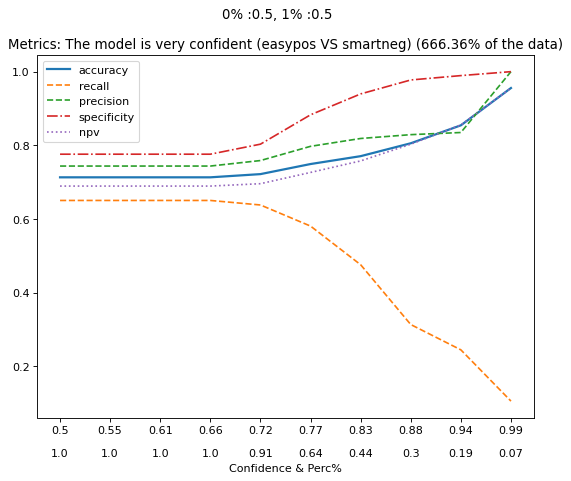

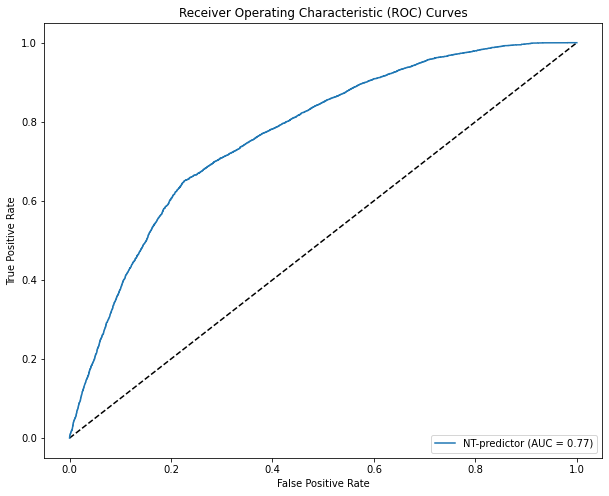

In [52]:
confidence_level = 0.7
high_prob_pairs = easypos_smartneg[(easypos_smartneg.probability>confidence_level)|(easypos_smartneg.probability<(1-confidence_level))]

obtain_plot(balance_df(high_prob_pairs), n_original_df = easypos_smartneg.shape[0], title = f'Metrics: The model is very confident (easypos VS smartneg) ', n_conf = n_conf)
plot_roc_curves([{'prob': high_prob_pairs.probability, 'model_name': 'NT-predictor'}], high_prob_pairs.ground_truth)

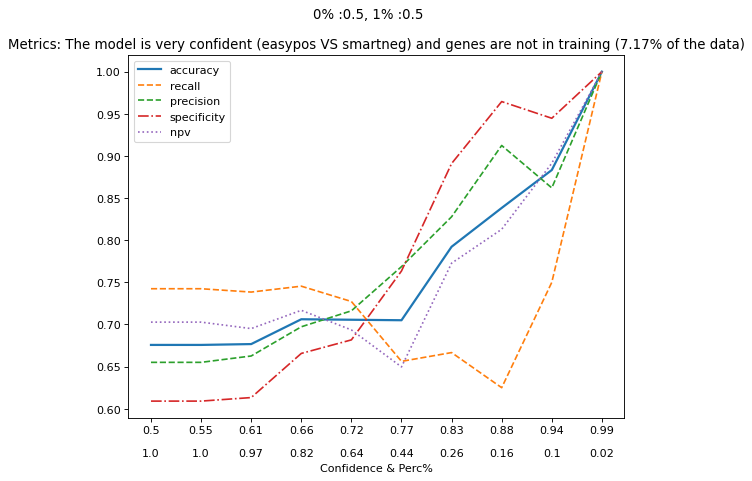

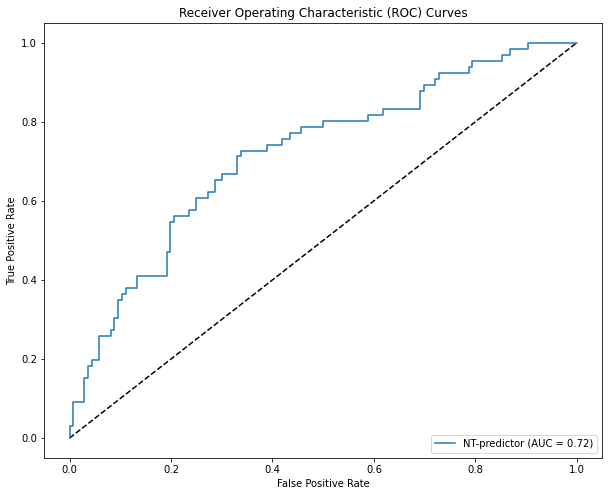

In [53]:
confidence_level = 0.6
high_prob_pairs = not_in_train[(not_in_train.probability>confidence_level)|(not_in_train.probability<(1-confidence_level))]
high_prob_pairs = high_prob_pairs[(high_prob_pairs.policy == 'easypos')|(high_prob_pairs.policy == 'smartneg')]

obtain_plot(balance_df(high_prob_pairs), n_original_df = res.shape[0], title = f'Metrics: The model is very confident (easypos VS smartneg) and genes are not in training ', n_conf = n_conf)
plot_roc_curves([{'prob': high_prob_pairs.probability, 'model_name': 'NT-predictor'}], high_prob_pairs.ground_truth)

In [36]:
# sns.kdeplot(list(pd.concat([easypos_smartneg.len_g1, easypos_smartneg.len_g2], axis = 0)), color = 'red', label = 'dataset')
# sns.kdeplot(list(pd.concat([high_prob_pairs.len_g1, high_prob_pairs.len_g2], axis = 0)), color = 'blue', label = 'high_confidence_pair')
# plt.title(f'Length distribution')
# plt.legend()

# Compare with INTARNA

In [54]:
intarna = pd.read_csv(os.path.join(intarna_dir, 'RANDOM', f'{HOW}500', f'{HOW}.csv'), sep = ';')
intarna['key'] = intarna.id1 + '_' + intarna.id2

# keep only the lower E_norm for each group
intarna.sort_values('E_norm', ascending = False, inplace=True)
intarna.drop_duplicates(subset='key', keep='first', inplace=True)
intarna = intarna.reset_index(drop = True)
intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
intarna['couples'] = intarna['couples'].astype(int)

# #merge with id of df_nt
# df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
# df_nt = df_nt[['couples', 'interacting']]
# df_nt['interacting'] = df_nt['interacting'].astype(int)

In [55]:
intarna = intarna.dropna()

In [56]:
res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')

In [57]:
auc_nt = []
auc_intarna = []

for i in range(500):
    # undersample 0 class
    res0 = res[res.ground_truth == 0]
    res1 = res[res.ground_truth == 1]
    balanced = pd.concat([res0.sample(res1.shape[0]), res1], axis = 0)

    fpr, tpr, _ = roc_curve(balanced.ground_truth, balanced.probability)
    roc_auc = auc(fpr, tpr)
    auc_nt.append(roc_auc)
    
    fpr, tpr, _ = roc_curve(abs(1 - balanced.ground_truth), balanced.E_norm)
    roc_auc = auc(fpr, tpr)
    auc_intarna.append(roc_auc)

In [58]:
print(np.mean(auc_nt), 
      np.mean(auc_intarna)
     )

0.6846430107794906 0.5387785249866437


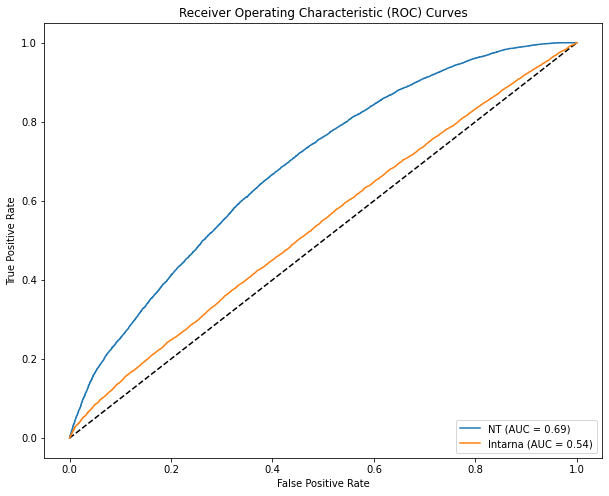

In [59]:
plot_roc_curves([{'prob': balanced.probability, 'model_name': 'NT'},
                 {'prob': abs(balanced.E_norm), 'model_name': 'Intarna'}
                ], balanced.ground_truth)

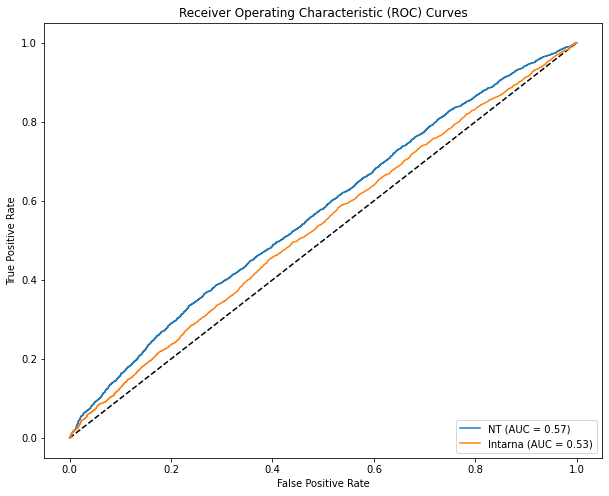

In [60]:
mouse = res[res.specie == 'mouse']
balanced_mouse = balance_df(mouse)
plot_roc_curves([{'prob': balanced_mouse.probability, 'model_name': 'NT'},
                 {'prob': abs(balanced_mouse.E_norm), 'model_name': 'Intarna'}
                ], balanced_mouse.ground_truth)

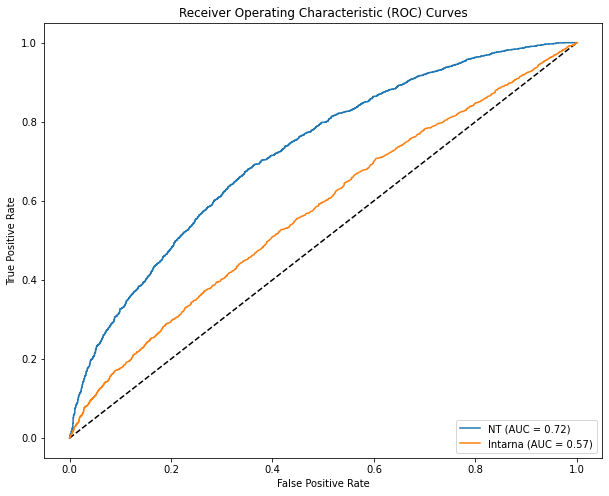

In [61]:
ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')]

vc = ephnen.ground_truth.value_counts()
assert vc.loc[1] > vc.loc[0]
n_to_exclude = vc.loc[1] - vc.loc[0]
ephnen_gt = ephnen[ephnen.ground_truth==1]
id_to_exclude = list(ephnen_gt.sample(frac = 1).head(n_to_exclude).id_sample)
ephnen_sampled = ephnen[~ephnen.id_sample.isin(id_to_exclude)]

plot_roc_curves([{'prob': ephnen_sampled.probability, 'model_name': 'NT'},
                 {'prob': abs(ephnen_sampled.E_norm), 'model_name': 'Intarna'}
                ], ephnen_sampled.ground_truth)

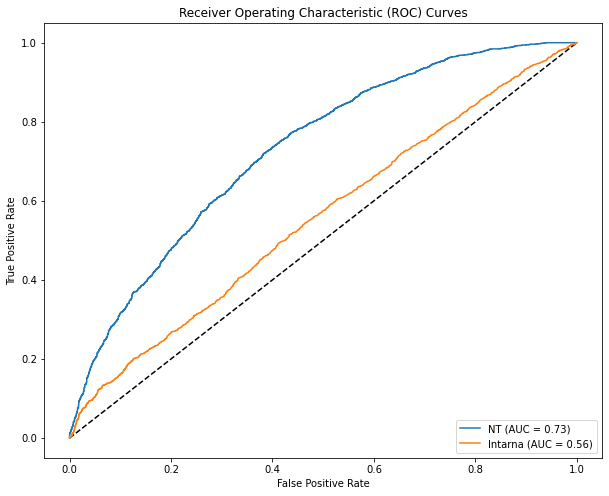

In [62]:
test = pd.read_csv(os.path.join(metadata_dir, 'RANDOM', f'{HOW}_sampled.csv'))
test = test[['id_gene1_sample', 'id_gene2_sample']]

res1 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene1_sample', 'id_gene2_sample'])
res2 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene2_sample', 'id_gene1_sample'])
easypos_smartneg = pd.concat([res1, res2], axis = 0)
easypos_smartneg.ground_truth.value_counts()

plot_roc_curves([{'prob': easypos_smartneg.probability, 'model_name': 'NT'},
                 {'prob': abs(easypos_smartneg.E_norm), 'model_name': 'Intarna'}
                ], easypos_smartneg.ground_truth)

In [63]:
easypos_smartneg = res[res.policy.isin(['easypos', 'smartneg'])]

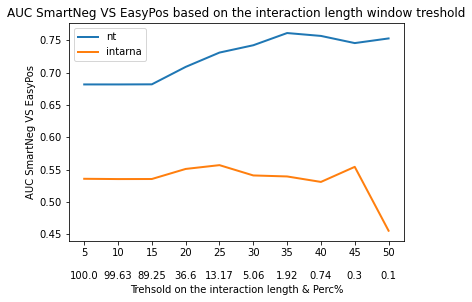

In [64]:
def obtain_auc_and_perc(treshold, res, test500, balance = True, intarna = False):
    original_res_shape = res.shape[0]
    #take only big windows
    subset = test500[ (abs(test500.seed_x1 - test500.seed_x2) >treshold) & (abs(test500.seed_y1 - test500.seed_y2) > treshold) ]
    res = res[res.id_sample.isin(subset.couples)]
    
    perc = np.round((res.shape[0] / original_res_shape)*100, 2)
    
    if balance:
        res = balance_df(res)
    
    if intarna:
        fpr, tpr, _ = roc_curve(abs(1 - res.ground_truth), res.E_norm)
        roc_auc = auc(fpr, tpr)
    else:
        fpr, tpr, _ = roc_curve(res.ground_truth, res.probability)
        roc_auc = auc(fpr, tpr)
    
    return roc_auc, perc

tresholds = np.linspace(5, 50, 10).astype(int)
aucs_nt = []
aucs_intarna = []
percs = []
for treshold in tresholds:
    roc_auc, perc = obtain_auc_and_perc(treshold, easypos_smartneg, test500, balance = False, intarna = False)
    aucs_nt.append(roc_auc)
    roc_auc, perc = obtain_auc_and_perc(treshold, easypos_smartneg, test500, balance = False, intarna = True)
    aucs_intarna.append(roc_auc)
    percs.append(perc)

merged_x_axis = []
for i in range(0, len(percs)):
    tuple_to_print = (np.round(tresholds[i],2), np.round(percs[i], 2))
    merged_x_axis.append('\n\n'.join(str(x) for x in tuple_to_print))

plt.title('AUC SmartNeg VS EasyPos based on the interaction length window treshold')

plt.plot(merged_x_axis, aucs_nt, label = 'nt', linewidth=2)
plt.plot(merged_x_axis, aucs_intarna, label = 'intarna', linewidth=2)

plt.xlabel(f"Trehsold on the interaction length & Perc%")
plt.ylabel(f"AUC SmartNeg VS EasyPos")
plt.legend()

#### Compare AUC based on confidence

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


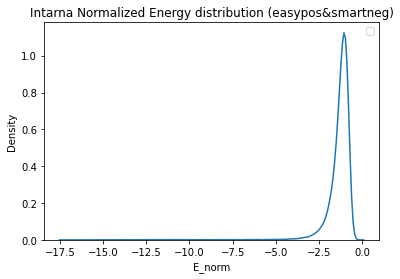

In [65]:
sns.kdeplot(easypos_smartneg.reset_index(drop = True).E_norm)
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

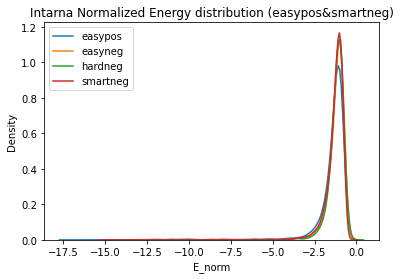

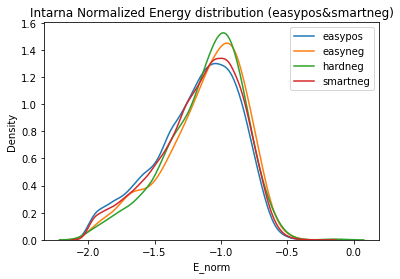

In [66]:
sns.kdeplot(res[res.policy == 'easypos'].E_norm, label = 'easypos')
sns.kdeplot(res[res.policy == 'easyneg'].E_norm, label = 'easyneg')
sns.kdeplot(res[res.policy == 'hardneg'].E_norm, label = 'hardneg')
sns.kdeplot(res[res.policy == 'smartneg'].E_norm, label = 'smartneg')
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

treshold_plot = -2
sns.kdeplot(res[(res.policy == 'easypos')&(res.E_norm>treshold_plot)].E_norm, label = 'easypos')
sns.kdeplot(res[(res.policy == 'easyneg')&(res.E_norm>treshold_plot)].E_norm, label = 'easyneg')
sns.kdeplot(res[(res.policy == 'hardneg')&(res.E_norm>treshold_plot)].E_norm, label = 'hardneg')
sns.kdeplot(res[(res.policy == 'smartneg')&(res.E_norm>treshold_plot)].E_norm, label = 'smartneg')
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

In [67]:
def plot_ROC_based_on_confidence(df, how = 'intarna', treshold = 0.05):
    if how == 'intarna':
        subset = df[
            (df.E_norm <= df.E_norm.quantile(treshold))|
            (df.E_norm >= df.E_norm.quantile(1-treshold))
        ]
    elif how == 'nt':
        subset = df[
            (df.probability <= treshold)|
            (df.probability >= (1-treshold))
        ]
    else:
        raise NotImplementedError
    print('perc of the total data: ', np.round(subset.shape[0]/df.shape[0], 3)*100, '%')
    plot_roc_curves([{'prob': subset.probability, 'model_name': 'NT'},
                 {'prob': abs(subset.E_norm), 'model_name': 'Intarna'}
                ], subset.ground_truth)

perc of the total data:  20.1 %


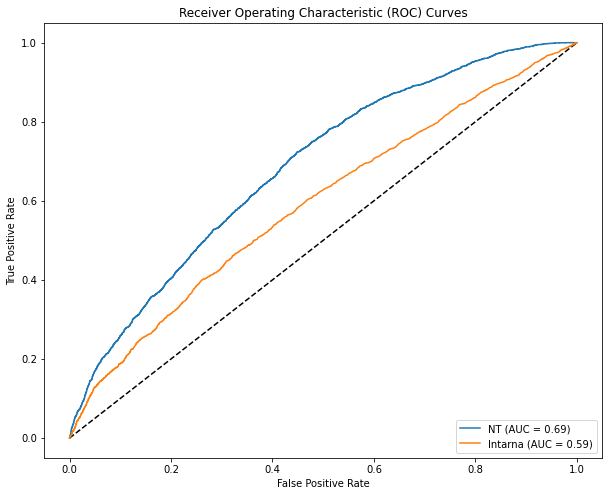

In [68]:
plot_ROC_based_on_confidence(easypos_smartneg, treshold = 0.1)

perc of the total data:  25.8 %


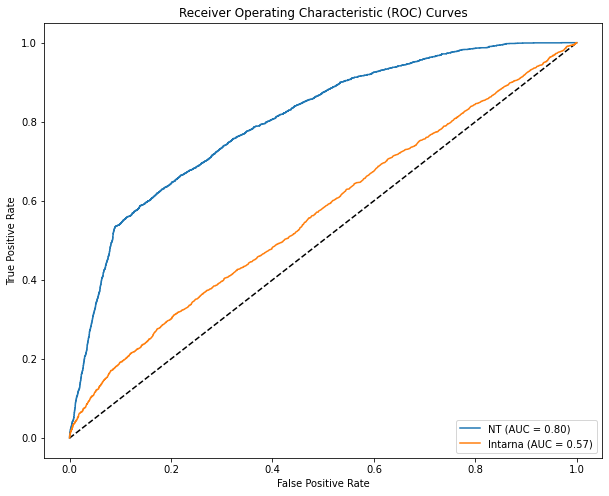

In [69]:
plot_ROC_based_on_confidence(easypos_smartneg, how = 'nt', treshold = 0.2)

Text(0.5, 0, 'Confidence & Perc%')

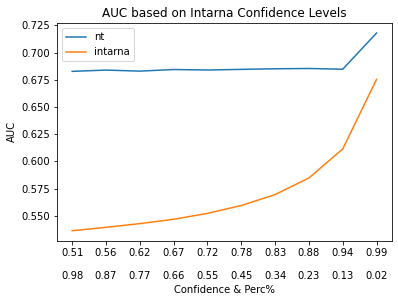

In [70]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(easypos_smartneg, how = 'intarna', n_values = 10)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on Intarna Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

Text(0.5, 0, 'Confidence & Perc%')

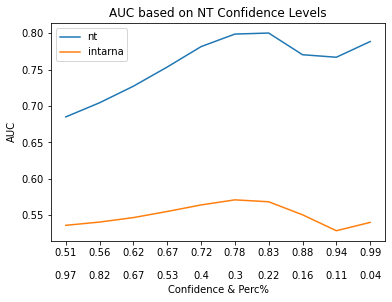

In [71]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(easypos_smartneg, how = 'nt', n_values = 10)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on NT Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

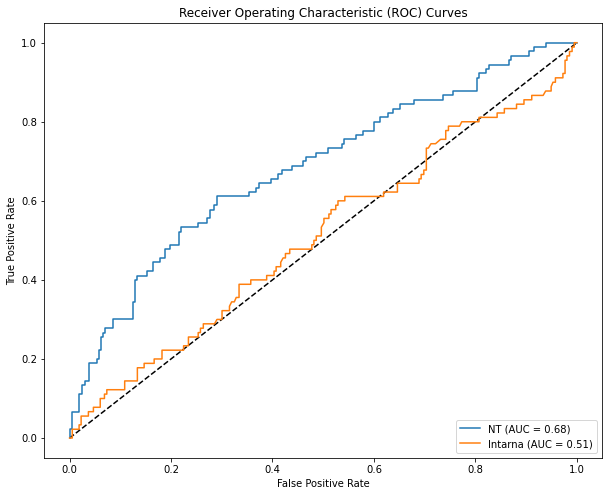

In [72]:
n_iters = 100

lists = []

for i in range(n_iters):

    not_in_train_epsn = easypos_smartneg[~(easypos_smartneg.gene1_original.isin(df_train_genes) | easypos_smartneg.gene2_original.isin(df_train_genes))]

    negs = not_in_train_epsn[not_in_train_epsn.ground_truth == 0]
    poss = not_in_train_epsn[not_in_train_epsn.ground_truth == 1]

    not_in_train_epsn = pd.concat([negs.sample(len(poss)), poss], axis = 0)
    lists.append(not_in_train_epsn)

not_in_train_epsn = pd.concat(lists, axis = 0)

plot_roc_curves([{'prob': not_in_train_epsn.probability, 'model_name': 'NT'},
                 {'prob': abs(not_in_train_epsn.E_norm), 'model_name': 'Intarna'}
                ], not_in_train_epsn.ground_truth)

In [73]:
treshold = 0.7
subset_where_disagree = easypos_smartneg[
                (easypos_smartneg.probability >= treshold)|
                (easypos_smartneg.probability <= (1-treshold))
            ]

In [74]:
subset_where_disagree.ground_truth.value_counts()

0    13906
1     5825
Name: ground_truth, dtype: int64

Text(0.5, 0, 'Confidence & Perc%')

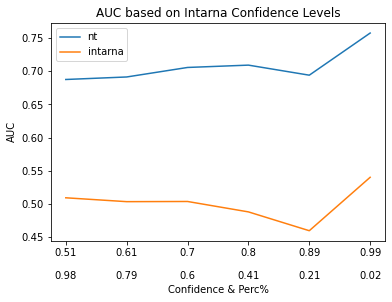

In [75]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(not_in_train_epsn, how = 'intarna', n_values = 6)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on Intarna Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

In [76]:
confidence_space = np.linspace(0.51, 0.99, 6)
for i in range(6):
    treshold = 1-confidence_space[i]
    subset = not_in_train_epsn[
        (not_in_train_epsn.E_norm <= not_in_train_epsn.E_norm.quantile(treshold))|
        (not_in_train_epsn.E_norm >= not_in_train_epsn.E_norm.quantile(1-treshold))
    ]
fpr, tpr, _ = roc_curve(abs(1 - subset.ground_truth), subset.E_norm)
roc_auc = auc(fpr, tpr)
roc_auc

0.5404040404040404

Text(0.5, 0, 'Confidence & Perc%')

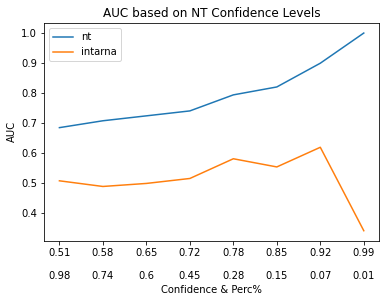

In [77]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(not_in_train_epsn, how = 'nt', n_values = 8)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on NT Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

# XAI

In [62]:
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, 'RANDOM', f'df_genes_nt.csv'))

DEVICE = 'cpu'

args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)

# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**args_dict)
args.resume = os.path.join(checkpoint_dir, 'best_model.pth') # best_model

device = torch.device(DEVICE)
model = build_model(args)

checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

model.to(device)
model.eval()

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


BinaryClassifierNT(
  (nt_projection_module): NTProjectionModule(
    (conv1d): Conv1d(2560, 0, kernel_size=(1,), stride=(1,))
    (bn): BatchNorm1d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (top_classifier): MLP(
    (input_layer): Sequential(
      (0): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=5120, out_features=512, bias=True)
    )
    (hidden_layers): ModuleList()
    (output_layer): Linear(in_features=512, out_features=800, bias=True)
    (activation_functions): ModuleList(
      (0): Tanh()
    )
    (dropout_layers): ModuleList(
      (0): Dropout(p=0.01, inplace=False)
    )
  )
  (small_cnn): SmallCNN(
    (conv1): Conv2d(800, 400, kernel_size=(2, 2), stride=(1, 1))
    (conv2): Conv2d(400, 600, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
    (maxpool2d): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (tanh): Tanh()
    (global_avg_pool): AdaptiveAvgPool2d(o

In [63]:
xai = pd.read_csv(os.path.join(checkpoint_dir, f'gradcam_results_{HOW}500.csv'))

In [64]:
xai = xai.merge(res.filter([
    'couples', 'gene1_pc', 'gene2_pc', 'original_length1', 'original_length2', 'id_sample', 'g1', 'g2', 'gene1_original', 'gene2_original'
], axis = 1), left_on = 'id', right_on = 'id_sample')

In [65]:
gradcam_results = xai[xai.probability>0.5]

iou_value: 0.0044
iou_value_tr: 0.0042
iou_value_rand: 0.0028


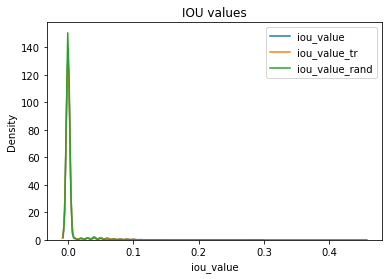

intensity: 0.5825
intensity_tr: 0.1756
intensity_rand: 0.5


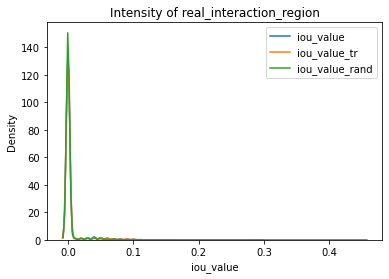

euclidean: 0.4764
euclidean_rand: 0.5287
euclidean_bbox_tr: 0.5042


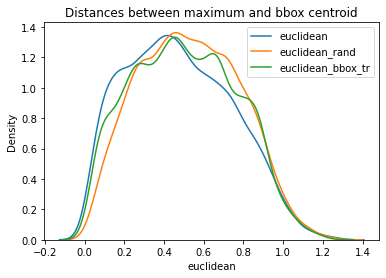

cos_sim: 0.05
cos_sim_tr: 0.03
cos_sim_rand: 0.04


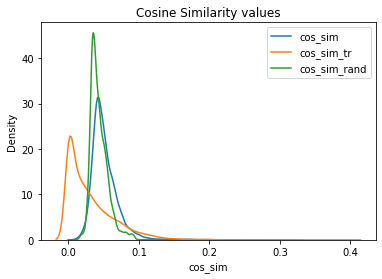

In [66]:
iou_columns = ['iou_value', 'iou_value_tr', 'iou_value_rand']
for c in iou_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'IOU values')
plt.legend()
plt.show()

intensity_columns = ['intensity', 'intensity_tr', 'intensity_rand']
for c in intensity_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
    
plt.title(f'Intensity of real_interaction_region')
plt.legend()
plt.show()

euclidean_columns = ['euclidean', 'euclidean_rand', 'euclidean_bbox_tr']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid')
plt.legend()
plt.show()

cosine_sim_columns = ['cos_sim', 'cos_sim_tr', 'cos_sim_rand']
for c in cosine_sim_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 2))}')

for c in cosine_sim_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Cosine Similarity values')
plt.legend()
plt.show()

#### Subset XAI results

In [67]:
df_nt = pd.read_csv(os.path.join(metadata_dir, 'RANDOM', f'df_nt.csv'))
regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
df_train = regex
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

euclidean: 0.4512
euclidean_rand: 0.4502


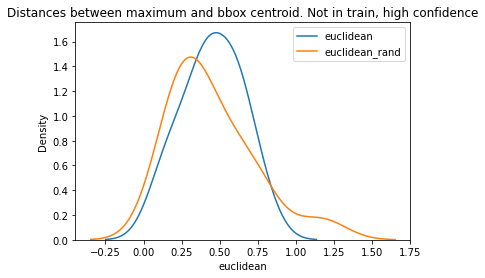

In [68]:
gradcam_results = xai[~(xai.gene1_original.isin(df_train_genes) | xai.gene2_original.isin(df_train_genes))]
gradcam_results = gradcam_results[(gradcam_results.probability>0.65)&(gradcam_results.probability<0.8)]

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid. Not in train, high confidence')
plt.legend()
plt.show()

In [69]:
def plot_query_results(query):
    for _, row in query.iterrows():
        x1_emb, x2_emb, y1_emb, y2_emb = int(np.round(row.x1/6)), int(np.round(row.x2/6)), int(np.round(row.y1/6)), int(np.round(row.y2/6))
        
        embedding1_path = os.path.join(embedding_dir, '32', row.gene1+'.npy')
        embedding2_path = os.path.join(embedding_dir, '32', row.gene2+'.npy')

        embedding1 = np.load(embedding1_path)[x1_emb:x2_emb :]
        embedding2 = np.load(embedding2_path)[y1_emb:y2_emb, :]

        rna1, rna2 = torch.as_tensor(embedding1).unsqueeze(0), torch.as_tensor(embedding2).unsqueeze(0)
        rna1, rna2 = torch.transpose(rna1, 1, 2), torch.transpose(rna2, 1, 2)

        rna1, rna2 = rna1.to(device), rna2.to(device)
        
        outputs = model(rna1, rna2)

        outputs[:, 1].backward()
        #print('prob:', outputs.softmax(-1)[:, 1])
        #print('degree:', row.abs_sum_diff)
        x1 = int(row.seed_x1-row.x1)
        x2 = int(row.seed_x2-row.x1)
        y1 = int(row.seed_y1-row.y1)
        y2 = int(row.seed_y2-row.y1)
        width = row.len1
        height = row.len2
        

        expl_matrix = gradcam(model, rna1, rna2, counterfactual = False, cnn_layer = 2)
        
        expl_matrix_reshaped = interpolate_expl_matrix(expl_matrix, height=height, width=width)
        
        # print(x1, x2, y1, y2)
        # print(expl_matrix_reshaped.shape)

        scaling_factor = 70

        plot_matrix(expl_matrix_reshaped, 
        [[y1, x1, y2-y1, x2-x1]], #crop_bbox =[x1hat, y1hat, what, hhat], 
        cmap ='viridis', 
        scaling_factor = scaling_factor)
        plt.show()

euclidean: 0.4472
euclidean_rand: 0.5277


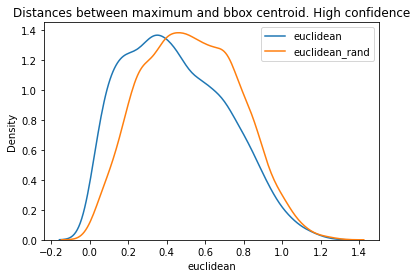

In [70]:
gradcam_results = xai[(xai.probability>0.75)]

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid. High confidence')
plt.legend()
plt.show()

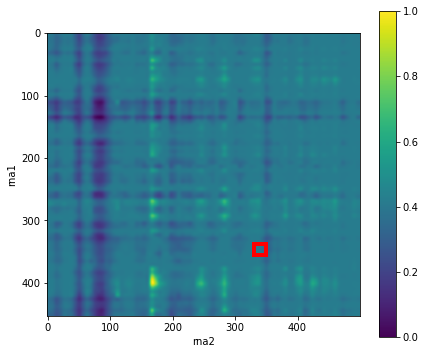

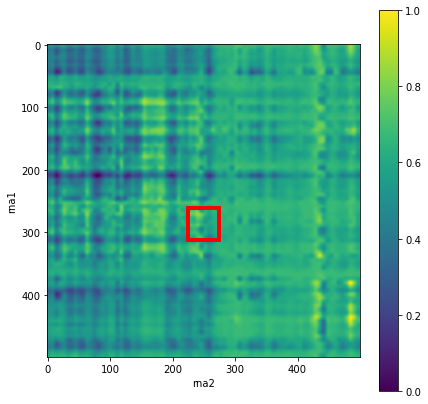

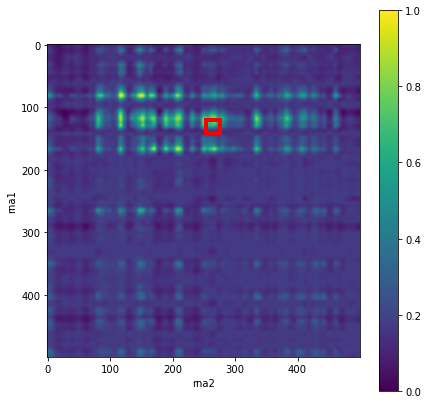

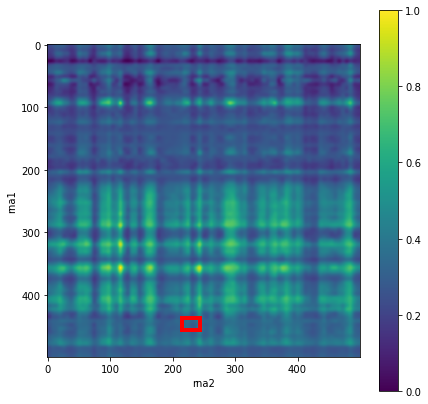

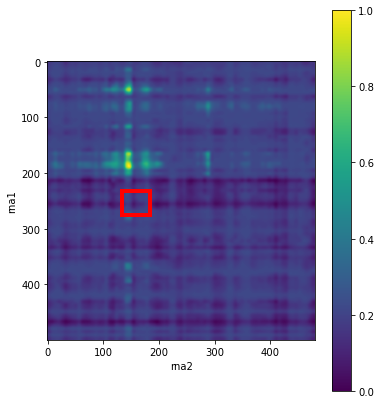

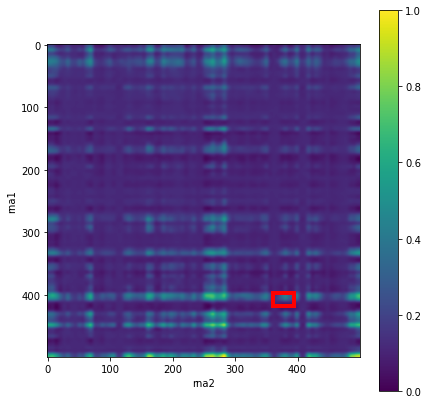

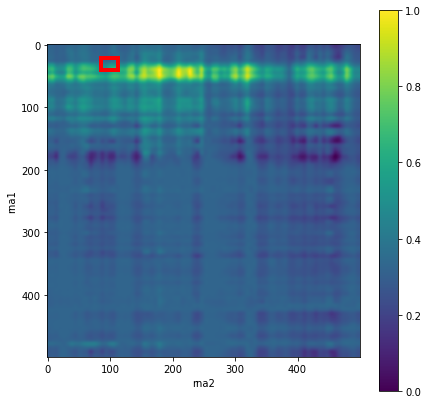

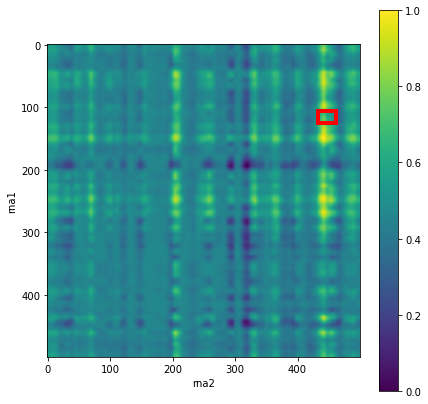

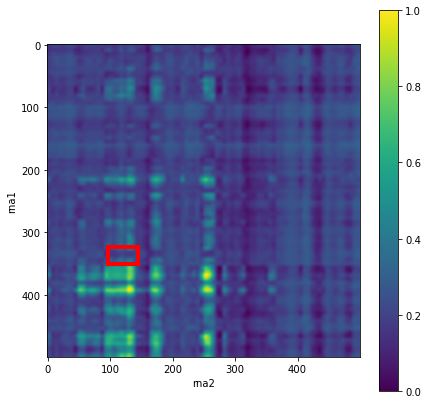

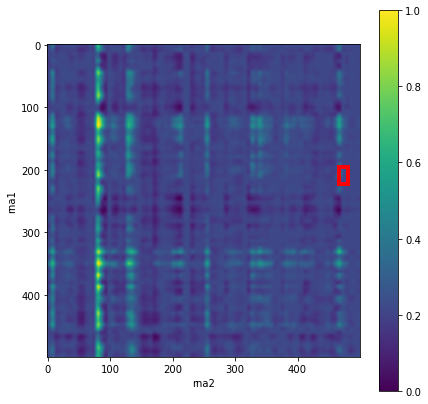

In [71]:
query = test500[test500.couples.isin(list(gradcam_results.id))]
plot_query_results(query.sample(10))

Not in training

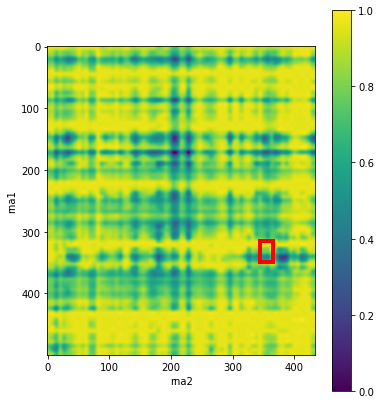

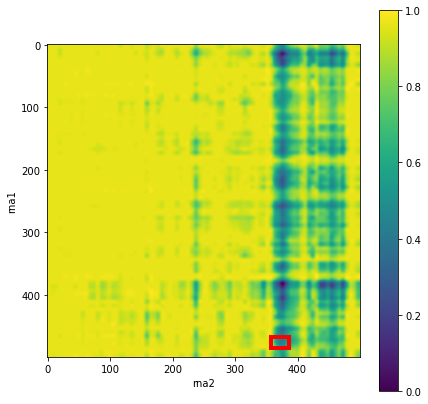

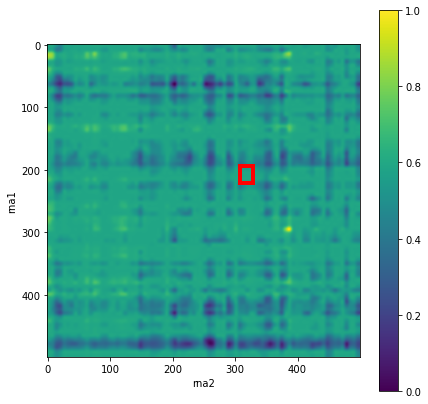

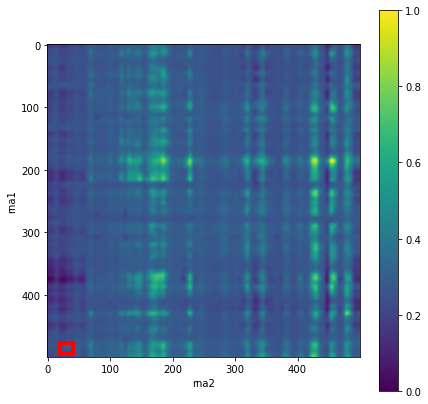

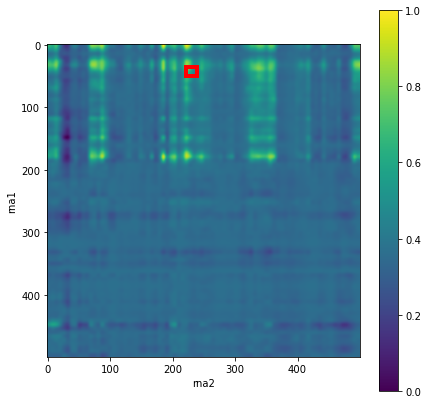

In [72]:
gradcam_results = xai[~(xai.gene1_original.isin(df_train_genes) | xai.gene2_original.isin(df_train_genes))]
gradcam_results = gradcam_results[(gradcam_results.probability>0.5)]

query = test500[test500.couples.isin(list(gradcam_results.id))].reset_index(drop = True)
query['gene1_original'] = query.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query['gene2_original'] = query.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query = query[ ~( (query.gene1_original.isin(df_train_genes)) | (query.gene2_original.isin(df_train_genes)) )]

plot_query_results(query.sample(5))

High confidence not in train

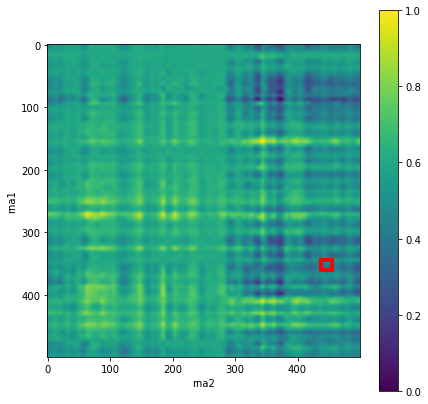

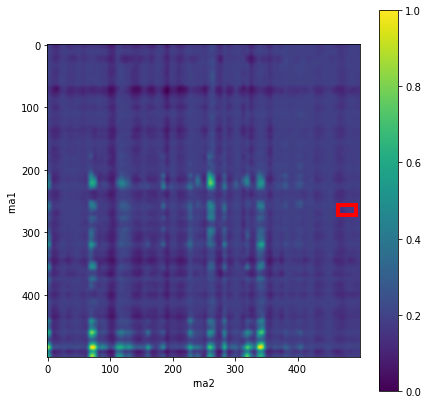

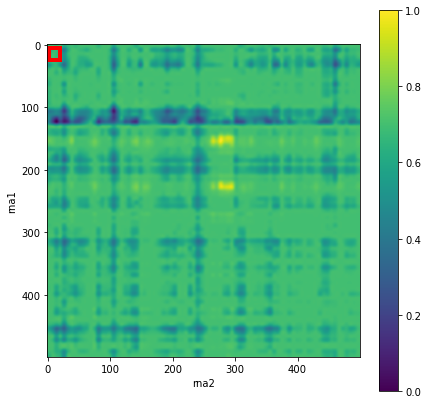

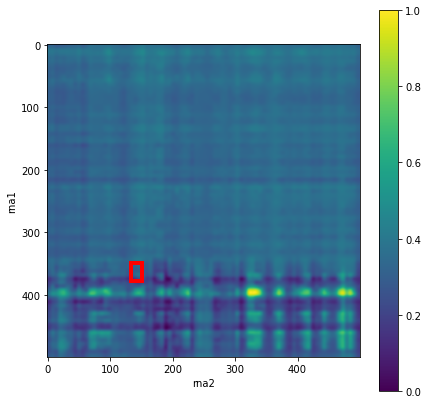

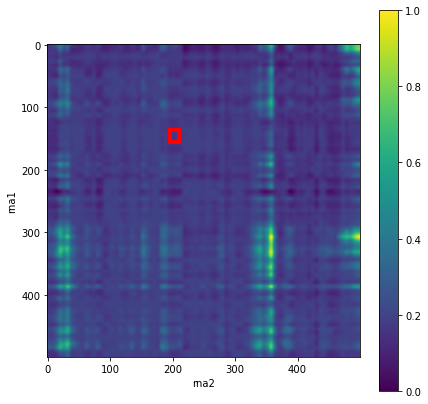

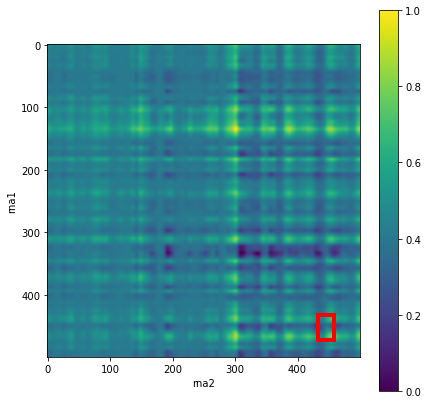

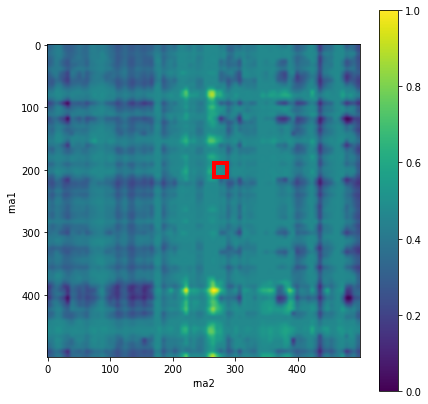

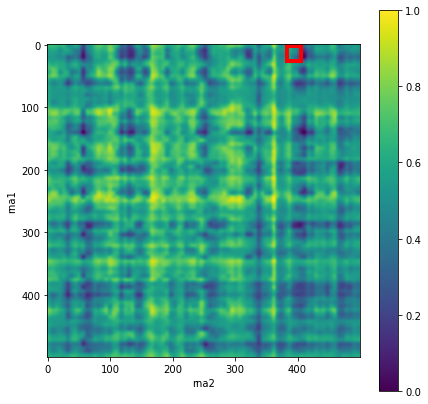

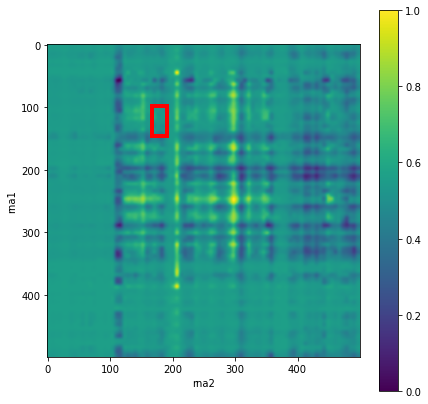

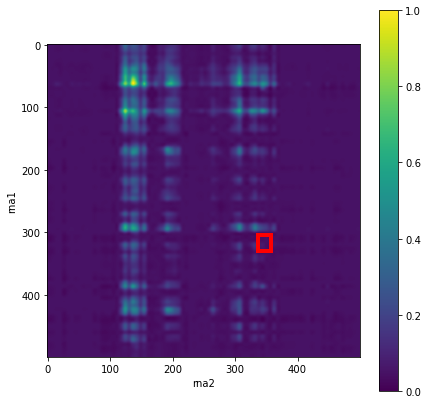

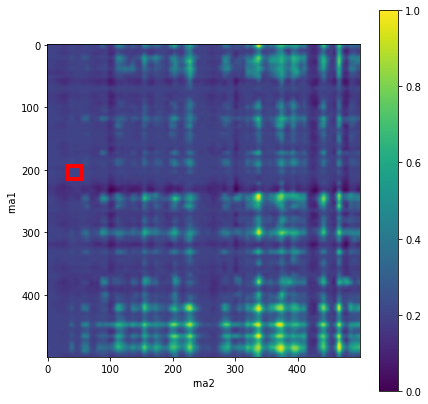

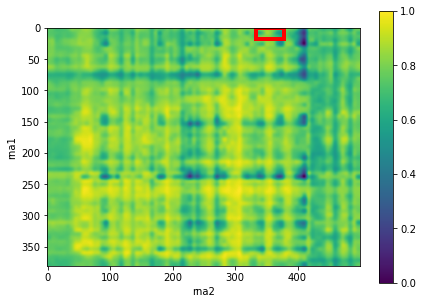

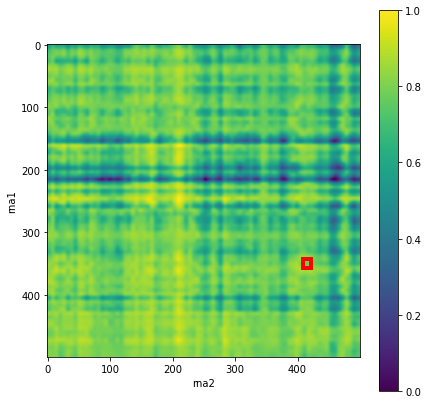

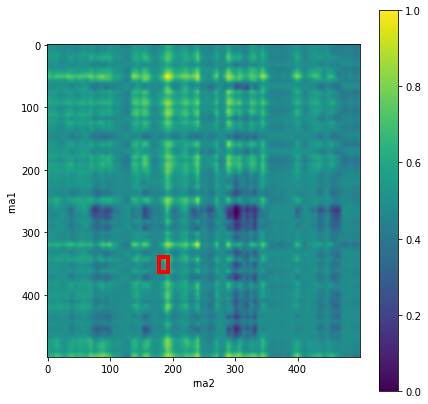

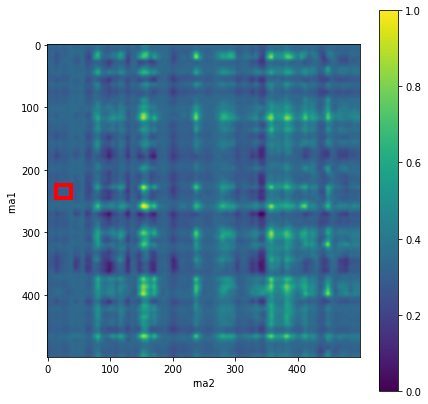

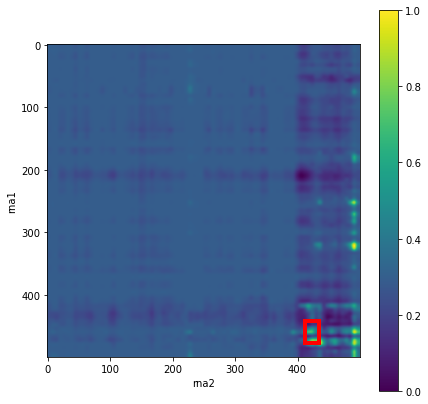

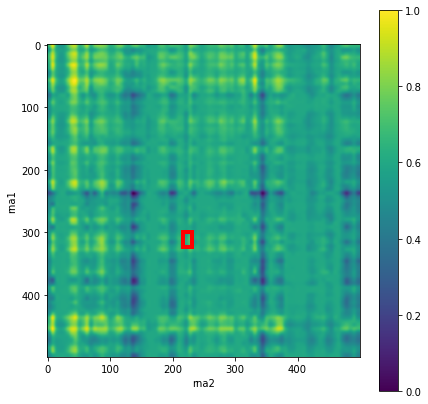

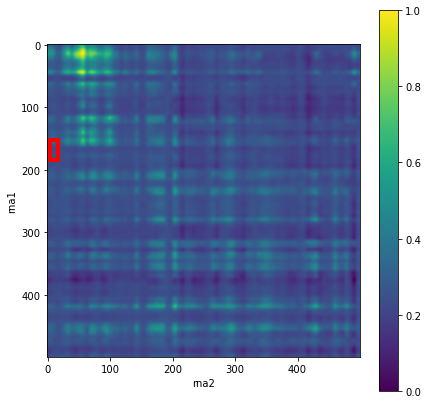

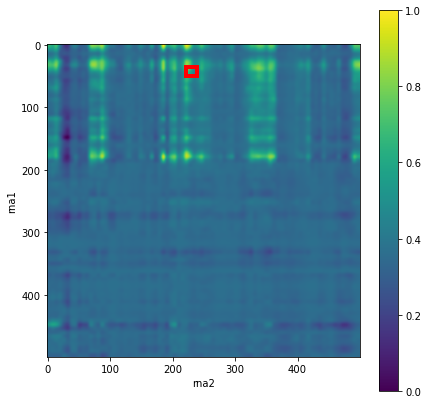

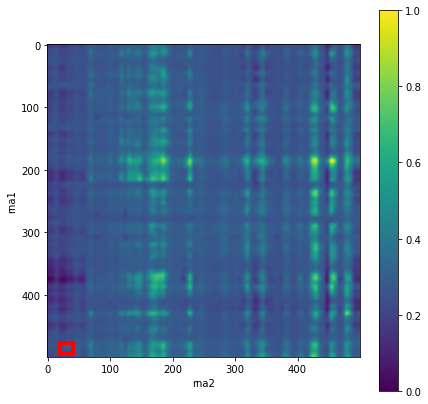

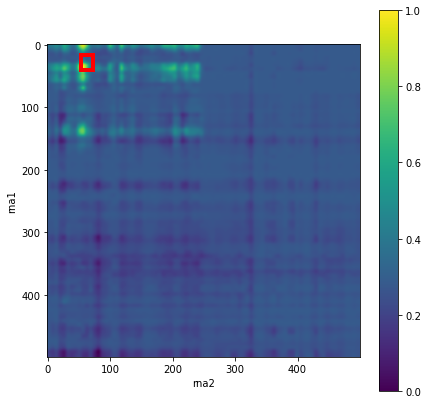

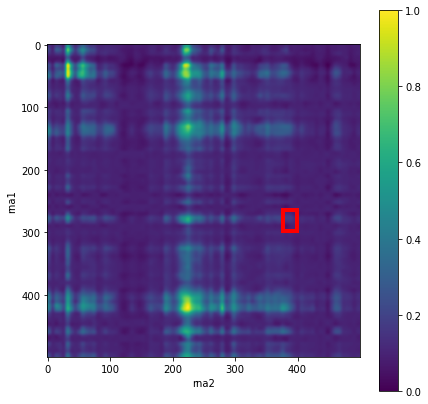

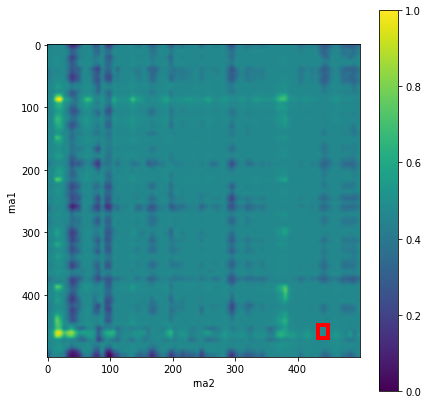

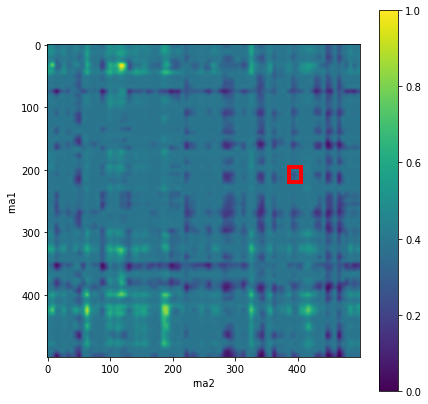

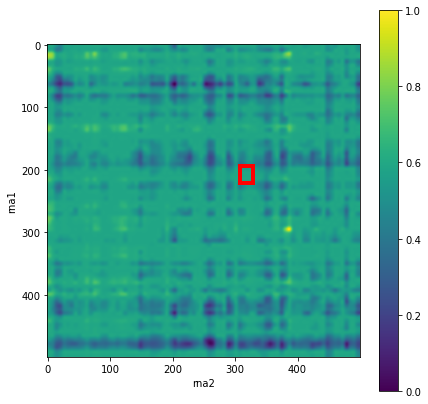

In [73]:
gradcam_results = xai[~(xai.gene1_original.isin(df_train_genes) | xai.gene2_original.isin(df_train_genes))]
gradcam_results = gradcam_results[(gradcam_results.probability>0.7)]

query = test500[test500.couples.isin(list(gradcam_results.id))].reset_index(drop = True)
query['gene1_original'] = query.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query['gene2_original'] = query.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query = query[ ~( (query.gene1_original.isin(df_train_genes)) | (query.gene2_original.isin(df_train_genes)) )]

plot_query_results(query.head(25))

False Negatives

In [225]:
# gradcam_results = xai
# gradcam_results = gradcam_results[(gradcam_results.probability<0.5)]

# query = test500[test500.couples.isin(list(gradcam_results.id))].reset_index(drop = True)
# query['gene1_original'] = query.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
# query['gene2_original'] = query.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
# query = query[ ~( (query.gene1_original.isin(df_train_genes)) | (query.gene2_original.isin(df_train_genes)) )]

# plot_query_results(query.sample(10))

False Negatives, not in train, almost 0.5

In [227]:
# gradcam_results = xai[~(xai.gene1_original.isin(df_train_genes) | xai.gene2_original.isin(df_train_genes))]
# gradcam_results = gradcam_results[(gradcam_results.probability<0.5)&((gradcam_results.probability>0.48))]

# query = test500[test500.couples.isin(list(gradcam_results.id))].reset_index(drop = True)
# query['gene1_original'] = query.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
# query['gene2_original'] = query.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
# query = query[ ~( (query.gene1_original.isin(df_train_genes)) | (query.gene2_original.isin(df_train_genes)) )]

# plot_query_results(query.head(10))

In [23]:
res = pd.read_csv(os.path.join(checkpoint_dir, f'{HOW}_results500.csv'))

# Drop all the pairs (they should be 60-70) that are present in the training set.
res = res[~res.couples.isin(gene_pairs_train_original)]

print(classification_report(res.ground_truth, res.prediction))

              precision    recall  f1-score   support

           0       0.77      0.72      0.74     30471
           1       0.47      0.54      0.50     14373

    accuracy                           0.66     44844
   macro avg       0.62      0.63      0.62     44844
weighted avg       0.67      0.66      0.66     44844



In [71]:
EXP = 'PARIS1' #can be 'PARIS1', 'PARIS2'
N_READS = 1


#OBTAIN High Quality Reads
filename = os.path.join(original_files_dir, 'Tx.RI_ALL.specie.no_abundant.filter_rep.no_mirna.no_mito.no_cds_cds.bedpe')

rows = []
with open(filename)as f:
    for line in f:
        L = line.strip().split()
        rows.append(L)
        
all_interactions = pd.DataFrame(rows, columns = ['tr1', 'x1', 'x2', 'tr2', 'y1', 'y2', 'name', 'n_reads', 'strand1', 'strand2', 'other_id', 'experiment'] )

all_interactions = all_interactions[~all_interactions.experiment.isin(['hs_RIC-seq__HeLa_merge.InterGene.arms', 'mm_MARIO__mES'])] #take only paris

all_interactions[['x1', 'x2', 'y1', 'y2', 'n_reads']] = all_interactions[['x1', 'x2', 'y1', 'y2', 'n_reads']].apply(pd.to_numeric)

#they are already mapped so the strand should be always '+'
assert (all_interactions.strand1 == all_interactions.strand2).all()
assert set(all_interactions.strand1) == {'+'}


#all_interactions = all_interactions.loc[(all_interactions['name'].str.count('PARIS1')>0)&(all_interactions['n_reads']>1)]
all_interactions = all_interactions.loc[(all_interactions['name'].str.count(EXP)>0)]


info = pd.read_csv(os.path.join(original_files_dir, 'index_bio_regions.Tx.RI_ALL.txt'), sep = '\t')
merged = all_interactions.merge(info, on = 'name')

assert (merged.tr1 == merged.chrom_1).all()
assert (merged.tr2 == merged.chrom_2).all()
assert (merged.x1 == merged.start_1).all()
assert (merged.x2 == merged.end_1).all()
assert (merged.y1 == merged.start_2).all()
assert (merged.y2 == merged.end_2).all()
assert (merged.strand_1 == merged.strand_2).all()
assert set(merged.strand_1) == {'+'}

merged = merged.drop(['Unnamed: 0','chrom_1', 'chrom_2', 'start_1', 'end_1', 'start_2', 'end_2', 'strand_1', 'strand_2',
             'score', 'external_gene_name_1', 'external_gene_name_2', 'chrom_1_localization', 'chrom_2_localization', 
            'gene_biotype_1', 'gene_biotype_2'], axis = 1)


def get_couple_id(g1, g2, needed_to_swap = False):
    l = sorted([g1, g2])
    if needed_to_swap:
        need_to_swap = False if l[0] == g1 else True
        return '_'.join(l), need_to_swap
    else:
        return '_'.join(l)

    
hq_reads = merged[merged.n_reads>N_READS][['ensembl_gene_id_1', 'ensembl_gene_id_2']].apply(lambda x: get_couple_id(x.ensembl_gene_id_1, x.ensembl_gene_id_2), axis = 1)
hq_reads = set(hq_reads)

subset_hq_reads = res[res.couples.isin(hq_reads)]

subset_hq_reads = subset_hq_reads[subset_hq_reads.policy.isin(['easypos'])]

n_hq_reads = subset_hq_reads.shape[0]
print('# of high quality reads positive samples:', n_hq_reads)
print('accuracy on positive class over high quality reads:', (subset_hq_reads.prediction == subset_hq_reads.ground_truth).sum()/n_hq_reads)

# of high quality reads positive samples: 56
accuracy on positive class over high quality reads: 0.5892857142857143
